In [28]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(42)  # For reproducibility
num_samples = 10000

#### 1- Implement a uniform scalar quantizer function with the header

In [40]:
def UniformQuantizer(in_val, n_bits, xmax, m):
    L = 2 ** n_bits
    delta = 2 * xmax / L
    offset = (m * delta) / 2 - xmax
    shifted_input = in_val - offset
    clipped_input = np.clip(shifted_input, 0, 2 * xmax - delta / 2)
    q_ind = np.floor(clipped_input / delta).astype(int)
    q_ind = np.clip(q_ind, 0, L-1)
    return q_ind

#### 2- Implement a uniform scaler de-quantizer function with the header

In [30]:
def UniformDequantizer(q_ind, n_bits, xmax, m):
    L = 2 ** n_bits
    delta = 2 * xmax / L
    offset = (m * delta) / 2 - xmax
    deq_val = q_ind * delta + delta / 2 + offset
    return deq_val

#### 3- Test the quantizer/dequantizer functions on a deterministic input

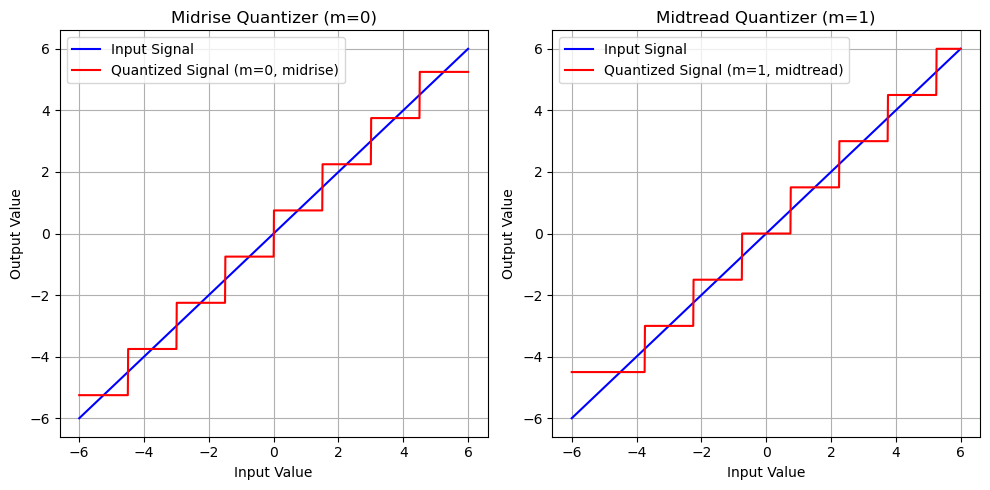

In [41]:

x = np.arange(-6, 6.01, 0.01) # Ramp signal
n_bits = 3
xmax = 6

q_ind_rise = UniformQuantizer(x, n_bits, xmax, 0)
deq_val_rise = UniformDequantizer(q_ind_rise, n_bits, xmax, 0)

q_ind_tread = UniformQuantizer(x, n_bits, xmax, 1)
deq_val_tread = UniformDequantizer(q_ind_tread, n_bits, xmax, 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(x, x, 'b-', label='Input Signal')
plt.plot(x, deq_val_rise, 'r-', label='Quantized Signal (m=0, midrise)')
plt.grid(True)
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.title('Midrise Quantizer (m=0)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x, x, 'b-', label='Input Signal')
plt.plot(x, deq_val_tread, 'r-', label='Quantized Signal (m=1, midtread)')
plt.grid(True)
plt.xlabel('Input Value')
plt.ylabel('Output Value')
plt.title('Midtread Quantizer (m=1)')
plt.legend()

plt.tight_layout()
plt.show()

#### Calculate SNR for the quantized signal

In [32]:
def calculate_snr(input_signal, snr_values):
    quant_error = input_signal - deq_val
    signal_power = np.mean(input_signal ** 2)
    error_power = np.mean(quant_error ** 2)
    snr = signal_power / error_power
    snr_db = 10 * np.log10(snr)
    snr_values.append(snr_db)

#### 4- Now test your input on a random input signal 

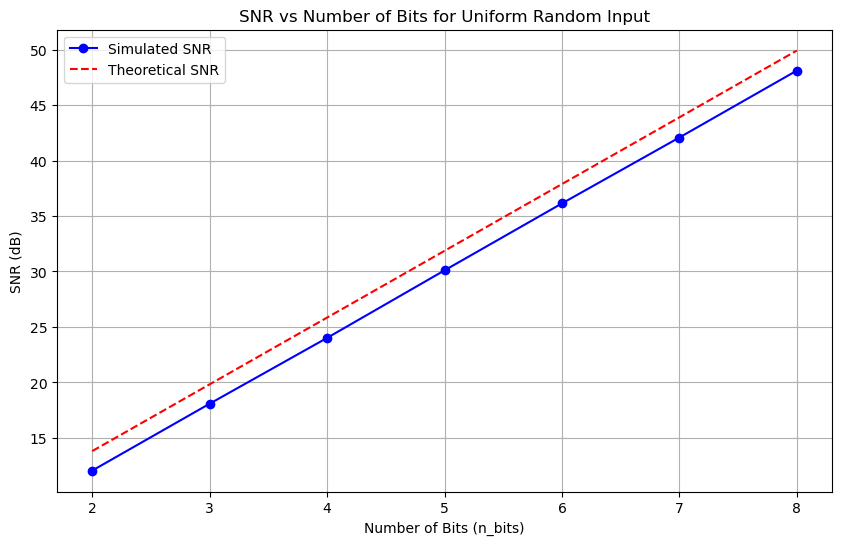

In [33]:
input_signal = np.random.uniform(-5, 5, num_samples)

n_bits_range = range(2, 9)

snr_values = []
for n_bits in n_bits_range:
    q_ind = UniformQuantizer(input_signal, n_bits, 5, 0)
    deq_val = UniformDequantizer(q_ind, n_bits, 5, 0)
    calculate_snr(input_signal, snr_values)

theoretical_snr = [6.02*n_bits + 1.76 for n_bits in n_bits_range]

plt.figure(figsize=(10, 6))
plt.plot(n_bits_range, snr_values, 'bo-', label='Simulated SNR')
plt.plot(n_bits_range, theoretical_snr, 'r--', label='Theoretical SNR')
plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Uniform Random Input')
plt.legend()
plt.show()

#### 5- Now test the uniform quantizer on a non-uniform random input

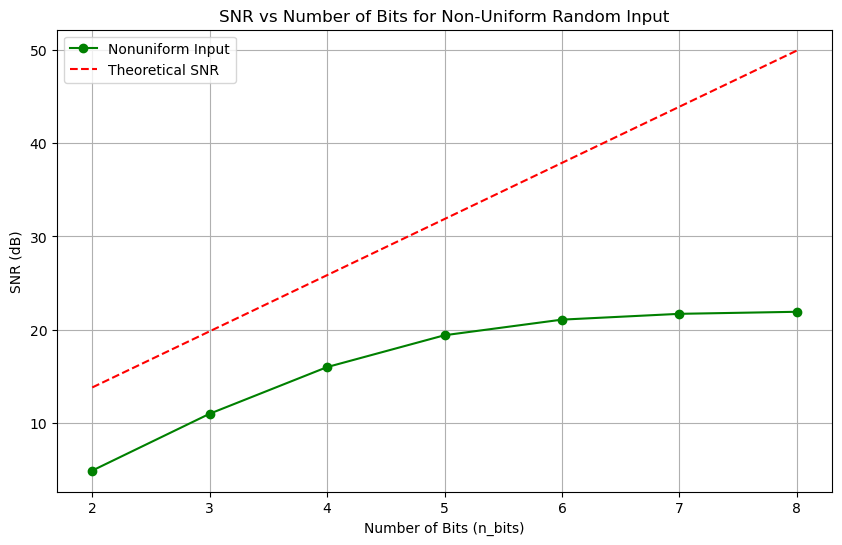

In [37]:
magnitudes = np.random.exponential(scale=1.0, size=num_samples)
polarities = np.random.choice([-1, 1], size=num_samples)
input_signal = magnitudes * polarities

n_bits_range = range(2, 9)

snr_values = []
for n_bits in n_bits_range:
    q_ind = UniformQuantizer(input_signal, n_bits, 5, 0)
    deq_val = UniformDequantizer(q_ind, n_bits, 5, 0)
    calculate_snr(input_signal, snr_values)

theoretical_snr = [6.02*n_bits + 1.76 for n_bits in n_bits_range]

plt.figure(figsize=(10, 6))
plt.plot(n_bits_range, snr_values, 'go-', label='Nonuniform Input')
plt.plot(n_bits_range, theoretical_snr, 'r--', label='Theoretical SNR')
plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Non-Uniform Random Input')
plt.legend()
plt.show()


#### 6- Now quantize the the non-uniform signal using a non-uniform μ law quantizer

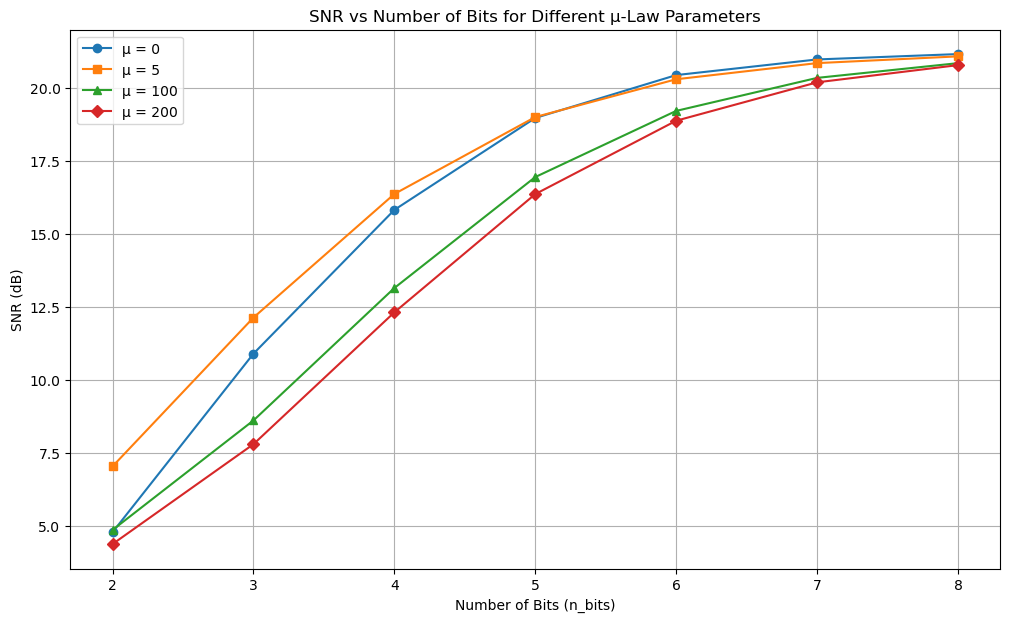

In [36]:
def mu_law_companding(x, mu):
    if mu == 0:
        return x
    x_norm = np.clip(x / 5, -1, 1)
    y = np.sign(x_norm) * np.log(1 + mu * np.abs(x_norm)) / np.log(1 + mu)
    return y * 5

def inverse_mu_law(y, mu):
    if mu == 0:
        return y
    y_norm = np.clip(y / 5, -1, 1)
    x = np.sign(y_norm) * (((1 + mu)**np.abs(y_norm) - 1) / mu)
    return x * 5

magnitudes = np.random.exponential(scale=1.0, size=num_samples)
polarities = np.random.choice([-1, 1], size=num_samples)
input_signal = magnitudes * polarities

mu_values = [0, 5, 100, 200]
n_bits_range = range(2, 9)
all_snr_values = []

for mu in mu_values:
    mu_snr_values = []

    for n_bits in n_bits_range:
        expanded_signal = mu_law_companding(input_signal, mu)
        q_ind = UniformQuantizer(expanded_signal, n_bits, 5, 0)
        deq_expanded = UniformDequantizer(q_ind, n_bits, 5, 0)
        deq_val = inverse_mu_law(deq_expanded, mu)
        calculate_snr(input_signal, mu_snr_values)
    
    all_snr_values.append(mu_snr_values)

plt.figure(figsize=(12, 7))
markers = ['o-', 's-', '^-', 'D-']

for i, mu in enumerate(mu_values):
    plt.plot(n_bits_range, all_snr_values[i], markers[i], label=f'μ = {mu}')

plt.grid(True)
plt.xlabel('Number of Bits (n_bits)')
plt.ylabel('SNR (dB)')
plt.title('SNR vs Number of Bits for Different μ-Law Parameters')
plt.legend()
plt.show()
